Train shape: (1460, 79)   Test shape: (1459, 79)
Numerical: 36   Categorical: 43

=== Fold 1 / 5 ===
ElasticNet  RMSE (log): 0.12231   RMSE($): 23,846
[LightGBM] [Info] Total Bins 3199
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 178
[LightGBM] [Info] Start training from score 12.030658
LightGBM    RMSE (log): 0.13941   RMSE($): 28,604
XGBoost     RMSE (log): 0.13760   RMSE($): 25,761
Blend (mean) RMSE (log): 0.12764   RMSE($): 24,872

=== Fold 2 / 5 ===
ElasticNet  RMSE (log): 0.11812   RMSE($): 24,878
[LightGBM] [Info] Total Bins 3197
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 181
[LightGBM] [Info] Start training from score 12.016898
LightGBM    RMSE (log): 0.11435   RMSE($): 26,241
XGBoost     RMSE (log): 0.11851   RMSE($): 30,334
Blend (mean) RMSE (log): 0.10934   RMSE($): 26,143

=== Fold 3 / 5 ===
ElasticNet  RMSE (log): 0.18071   RMSE($): 75,517
[LightGBM] [Info] Total Bins 3184
[LightGBM] 

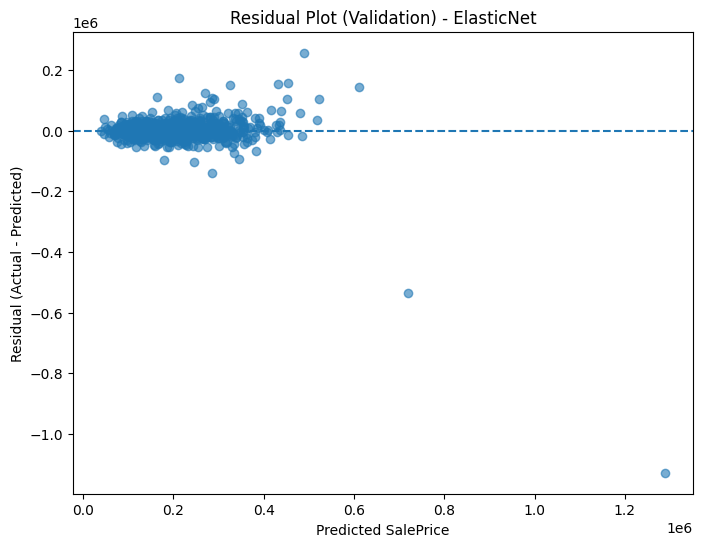

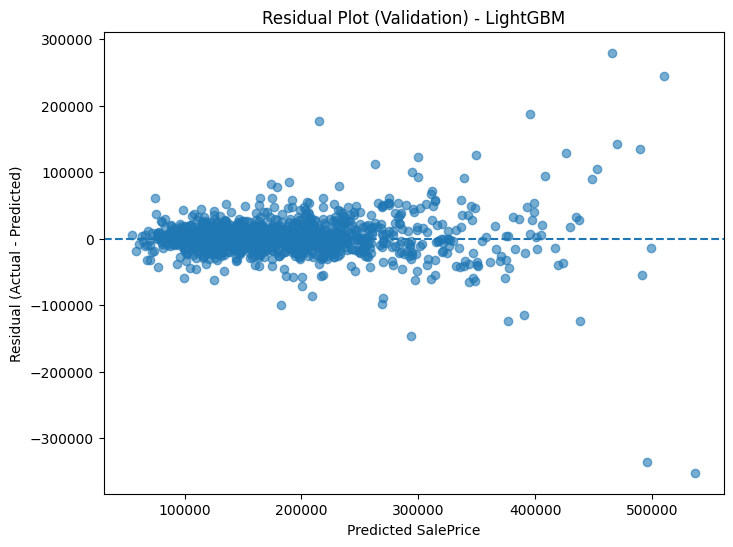

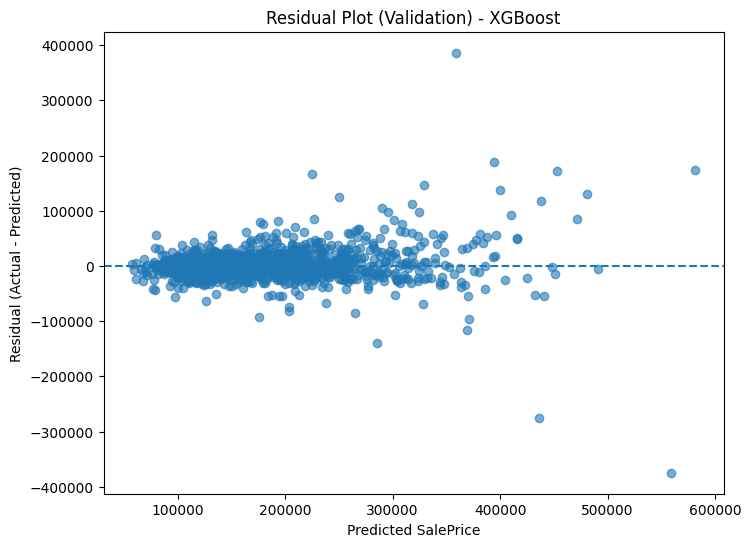

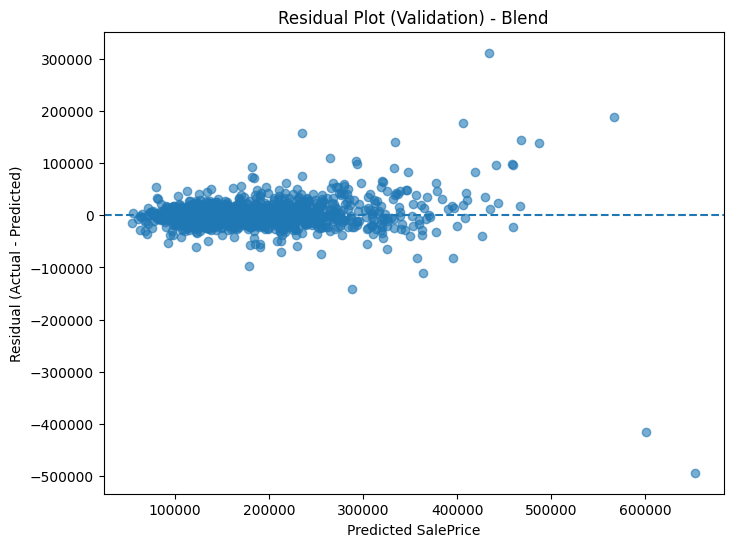

In [1]:
# ========= 1) Imports =========
import numpy as np
import pandas as pd
import warnings
from scipy import sparse
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.base import clone

import lightgbm as lgb
import xgboost as xgb

warnings.filterwarnings("ignore")

# ========= 2) Config =========
DATA_DIR = "/kaggle/input/house-prices-advanced-regression-techniques"
N_SPLITS = 5            # 可改成 10 讓 OOF 更穩
RANDOM_STATE = 42
PLOT_RESIDUALS = True   # 是否繪製殘差圖
META_ALPHAS = np.logspace(-3, 3, 25)  # RidgeCV 的 alpha 搜尋範圍

# ========= 3) Utils =========
def rmse(y_true, y_pred):
    """RMSE in the current space (callers決定是否在log空間)"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

def to_csr64(A):
    if sparse.issparse(A):
        return A.tocsr().astype(np.float64)
    return np.asarray(A, dtype=np.float64)

def safe_ohe():
    try:
        return OneHotEncoder(handle_unknown="ignore", sparse_output=True)
    except TypeError:
        return OneHotEncoder(handle_unknown="ignore", sparse=True)

# ========= 4) Load =========
train = pd.read_csv(f"{DATA_DIR}/train.csv")
test  = pd.read_csv(f"{DATA_DIR}/test.csv")

target = "SalePrice"
y_log = np.log1p(train[target]).astype("float64")
X = train.drop(columns=[target, "Id"])
X_test = test.drop(columns=["Id"])
test_ids = test["Id"]

# 基礎資訊列印
features_num = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
features_cat = X.columns.difference(features_num).tolist()
print(f"Train shape: {X.shape}   Test shape: {X_test.shape}")
print(f"Numerical: {len(features_num)}   Categorical: {len(features_cat)}")

# ========= 5) Preprocess（偏態修正 + 稀疏輸出 + 強制float64）=========
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("yeojohnson", PowerTransformer(method="yeo-johnson", standardize=True)),
    ("to64", FunctionTransformer(lambda A: A.astype(np.float64)))
])
categorical_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ohe", safe_ohe()),
    ("to64", FunctionTransformer(lambda A: A.astype(np.float64)))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, features_num),
        ("cat", categorical_pipe, features_cat),
    ],
    remainder="drop",
    sparse_threshold=1.0  # 強制稀疏矩陣（CSR/CSC）
)

# ========= 6) Base model params =========
enet_params = dict(alpha=0.0005, l1_ratio=0.5, max_iter=20000, random_state=RANDOM_STATE)

lgb_params = dict(
    objective="regression",
    learning_rate=0.01,
    n_estimators=10000,
    num_leaves=31,
    subsample=0.8,        # bagging
    colsample_bytree=0.9, # feature_fraction
    force_row_wise=True,
    random_state=RANDOM_STATE
)

xgb_params = dict(
    objective="reg:squarederror",
    learning_rate=0.01,
    n_estimators=10000,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",       # 若能用GPU，改 'gpu_hist'
    eval_metric="rmse",
    early_stopping_rounds=200,
    random_state=RANDOM_STATE
)

# ========= 7) OOF Stacking =========
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

n_models = 3
oof_meta = np.zeros((X.shape[0], n_models), dtype=float)
test_meta_accum = np.zeros((X_test.shape[0], n_models), dtype=float)

# 為殘差圖累積（各模型 & blend）
res_plots = {
    "ElasticNet": {"pred": [], "res": []},
    "LightGBM":   {"pred": [], "res": []},
    "XGBoost":    {"pred": [], "res": []},
    "Blend":      {"pred": [], "res": []},
}

fold_blend_scores = []

for fold, (tr_idx, va_idx) in enumerate(kf.split(X), start=1):
    print(f"\n=== Fold {fold} / {N_SPLITS} ===")
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr_log, y_va_log = y_log.iloc[tr_idx], y_log.iloc[va_idx]

    # fit preprocess on training fold only, then transform
    prep = clone(preprocess)
    prep.fit(X_tr, y_tr_log)
    X_tr_t = to_csr64(prep.transform(X_tr))
    X_va_t = to_csr64(prep.transform(X_va))
    X_test_t = to_csr64(prep.transform(X_test))

    # ----- ElasticNet -----
    enet = ElasticNet(**enet_params)
    enet.fit(X_tr_t, y_tr_log)
    pred_va_enet_log = enet.predict(X_va_t)
    rmse_enet_log = rmse(y_va_log, pred_va_enet_log)
    # 轉回原始空間做金額 RMSE
    rmse_enet_real = rmse(np.expm1(y_va_log), np.expm1(pred_va_enet_log))
    print(f"ElasticNet  RMSE (log): {rmse_enet_log:.5f}   RMSE($): {rmse_enet_real:,.0f}")

    # ----- LightGBM -----
    lgbm = lgb.LGBMRegressor(**lgb_params)
    lgbm.fit(
        X_tr_t, y_tr_log,
        eval_set=[(X_va_t, y_va_log)],
        callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
    )
    pred_va_lgb_log = lgbm.predict(X_va_t, num_iteration=lgbm.best_iteration_)
    rmse_lgb_log = rmse(y_va_log, pred_va_lgb_log)
    rmse_lgb_real = rmse(np.expm1(y_va_log), np.expm1(pred_va_lgb_log))
    print(f"LightGBM    RMSE (log): {rmse_lgb_log:.5f}   RMSE($): {rmse_lgb_real:,.0f}")

    # ----- XGBoost -----
    xgbr = xgb.XGBRegressor(**xgb_params)
    xgbr.fit(X_tr_t, y_tr_log, eval_set=[(X_va_t, y_va_log)], verbose=False)
    pred_va_xgb_log = xgbr.predict(X_va_t, iteration_range=(0, xgbr.best_iteration + 1))
    rmse_xgb_log = rmse(y_va_log, pred_va_xgb_log)
    rmse_xgb_real = rmse(np.expm1(y_va_log), np.expm1(pred_va_xgb_log))
    print(f"XGBoost     RMSE (log): {rmse_xgb_log:.5f}   RMSE($): {rmse_xgb_real:,.0f}")

    # ----- Save OOF meta features -----
    fold_meta = np.vstack([pred_va_enet_log, pred_va_lgb_log, pred_va_xgb_log]).T
    oof_meta[va_idx, :] = fold_meta

    # ----- Test meta (per-fold avg) -----
    test_meta_accum[:, 0] += enet.predict(X_test_t) / N_SPLITS
    test_meta_accum[:, 1] += lgbm.predict(X_test_t, num_iteration=lgbm.best_iteration_) / N_SPLITS
    test_meta_accum[:, 2] += xgbr.predict(X_test_t, iteration_range=(0, xgbr.best_iteration + 1)) / N_SPLITS

    # ----- Blend (mean) 觀察 -----
    blend_va_log = fold_meta.mean(axis=1)
    blend_score_log = rmse(y_va_log, blend_va_log)
    blend_score_real = rmse(np.expm1(y_va_log), np.expm1(blend_va_log))
    fold_blend_scores.append(blend_score_log)
    print(f"Blend (mean) RMSE (log): {blend_score_log:.5f}   RMSE($): {blend_score_real:,.0f}")

    # ====== 收集殘差（原始空間）以便畫圖 ======
    y_va_real = np.expm1(y_va_log)
    for name, pred_log in [
        ("ElasticNet", pred_va_enet_log),
        ("LightGBM",   pred_va_lgb_log),
        ("XGBoost",    pred_va_xgb_log),
        ("Blend",      blend_va_log),
    ]:
        pred_real = np.expm1(pred_log)
        res = y_va_real - pred_real
        res_plots[name]["pred"].append(pred_real)
        res_plots[name]["res"].append(res)

print("\nOOF Blend CV RMSE (log): {:.5f} ± {:.5f}".format(np.mean(fold_blend_scores), np.std(fold_blend_scores)))

# ========= 8) Meta model (RidgeCV) =========
meta = RidgeCV(alphas=META_ALPHAS, store_cv_values=False)
meta.fit(oof_meta, y_log)

# ========= 9) Submit =========
pred_test_log = meta.predict(test_meta_accum)
final_pred = np.expm1(pred_test_log)
submission = pd.DataFrame({"Id": test_ids, "SalePrice": final_pred})
submission.to_csv("/kaggle/working/submission.csv", index=False)
print("\n✅ Submission saved: /kaggle/working/submission.csv")
print(submission.head())

# ========= 10) Residual Plots =========
if PLOT_RESIDUALS:
    # 將各折收集的殘差串起來並畫圖（每個模型一張）
    for name in ["ElasticNet", "LightGBM", "XGBoost", "Blend"]:
        pred_all = np.concatenate(res_plots[name]["pred"])
        res_all  = np.concatenate(res_plots[name]["res"])

        plt.figure(figsize=(8,6))
        plt.scatter(pred_all, res_all, alpha=0.6)
        plt.axhline(0, linestyle="--")
        plt.title(f"Residual Plot (Validation) - {name}")
        plt.xlabel("Predicted SalePrice")
        plt.ylabel("Residual (Actual - Predicted)")
        plt.show()
